## Direct translation from R of the CNN

In [1]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

In [2]:
# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

### Load raster image and target variable

In [3]:
# 1. Load (Elevation) Data
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

# Dynamic path construction using os.path
data_path = os.path.join("..", "CNN_from_R", "images_for_CNN", "rainfall_raster_bound.tif")
rain, transform = load_rain_data(data_path)

# 2. Load the recharge data
clor = pd.read_csv("../Data/dat07_u.csv")
target_variable = "Recharge RC 50% mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", target_variable])

C:\Users\nefel\AppData\Local\Temp\ipykernel_19556\534251644.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv("../Data/dat07_u.csv")


In [4]:

# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)

# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


In [6]:
from pyproj import Transformer
from rasterio.enums import Resampling

def extract_terrain_images(gchem, gbelev_path, imagedim=32, imageres=250):
    # Open the raster file
    with rasterio.open(gbelev_path) as gbelev:
        # Initialize the array to store images
        imgs = np.zeros((len(gchem), imagedim, imagedim))
        
        # Create a grid of offsets
        offsets = np.linspace(-imageres * imagedim / 2 + imageres / 2, 
                              imageres * imagedim / 2 - imageres / 2, 
                              imagedim)
        
        # Set up a transformer to convert from latitude/longitude to the raster's CRS
        transformer = Transformer.from_crs("EPSG:4326", gbelev.crs, always_xy=True)
        
        # Iterate over each geochemical sample
        for i, (latitude, longitude) in enumerate(zip(gchem['lat'], gchem['lon'])):
            # Convert latitude and longitude to easting and northing
            easting, northing = transformer.transform(longitude, latitude)
            
            # Create a meshgrid of coordinates around the sample point
            x_coords, y_coords = np.meshgrid(easting + offsets, northing + offsets)
            coords = np.vstack((x_coords.flatten(), y_coords.flatten())).T
            
            # Extract elevation data using bilinear interpolation
            for j, (x, y) in enumerate(coords):
                row, col = gbelev.index(x, y)
                try:
                    imgs[i, j // imagedim, j % imagedim] = gbelev.read(1, window=((row, row+1), (col, col+1)), resampling=Resampling.bilinear)
                except IndexError:
                    imgs[i, j // imagedim, j % imagedim] = 0  # Handle out-of-bounds by setting to 0

        # Replace NaN values with 0
        imgs = np.nan_to_num(imgs)
    
    return imgs

In [10]:
precipitation_images = extract_terrain_images(clor_gdf, data_path)

ValueError: setting an array element with a sequence.

In [5]:
# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

In [6]:
# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
imgs_ann = extract_sample_centered_images(clor_gdf, rain, transform)

In [7]:
with rasterio.open(data_path) as src:
    transform = src.transform
    pixel_width = transform[0]   # `a` value: pixel size in x-direction
    pixel_height = -transform[4] # `e` value (negated because it's typically negative)
    print(f"Pixel size: {pixel_width} x {pixel_height}")

Pixel size: 0.05 x 0.05


#### Checking the centered images

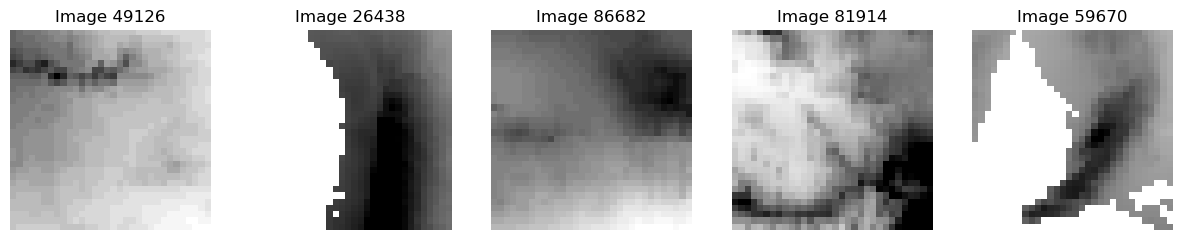

In [8]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(imgs_ann), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(imgs_ann[idx], cmap="binary")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Creating the location input

In [9]:
recharge_data = clor[['lat','lon','Rain mm/y', 'Recharge RC 50% mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]
# Assuming loc is a pandas DataFrame containing the columns: "Bng_easting", "Bng_northing", "elevation"
loc = recharge_data[['lat','lon','Rain mm/y', 'rainfall_seasonality', 'PET mm/y', 'elevation_mahd', 'distance_to_coast_km', 'ndvi_avg', 'clay_perc', 'soil_class']]

# Calculate column meansle 
loc_mean = loc.mean()

# Calculate column standard deviations
loc_sd = loc.std()

# Standardize the data (z-score normalization)
loc_ann = ((loc - loc_mean) / loc_sd).to_numpy()

In [10]:
recharge_data.shape[0]

98568

In [11]:
loc_ann[1]

array([ 0.54739326,  0.93351284, -0.13192523, -0.71667815,  0.66128752,
       -0.02089775,  0.15776049, -0.63913082,  1.42367874,  1.16900489])

### The network in pytorch

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class CNNModel(nn.Module):
    def __init__(self, n_channels_images, n_loc_inputs, dropratespat, dropratedense):
        super(CNNModel, self).__init__()
        
        # Convolutional stack
        self.conv1 = nn.Conv2d(in_channels=n_channels_images, out_channels=128, kernel_size=3, stride=3, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1)
        
        self.dropout_spatial = nn.Dropout2d(p=dropratespat)
        
        # Auxiliary input
        self.aux_dense = nn.Linear(n_loc_inputs, 1920)
        self.dropout_dense = nn.Dropout(p=dropratedense)
        
        # Main output
        self.main_dense1 = nn.Linear(128 + 1920, 1024)  # Adjust input size based on concatenation
        self.main_dense2 = nn.Linear(1024, 256)
        self.main_dense3 = nn.Linear(256, 2)
        
    def forward(self, x_conv, x_aux):
        # Convolutional stack
        x = F.relu(self.conv1(x_conv))
        x = self.dropout_spatial(x)
        
        x = F.relu(self.conv2(x))
        x = self.dropout_spatial(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout_spatial(x)
        
        x = F.relu(self.conv4(x))
        x = self.dropout_spatial(x)
        
        x = F.adaptive_avg_pool2d(x, (1, 1))  # Global average pooling
        x = torch.flatten(x, 1)
        
        # Auxiliary input
        aux = F.relu(self.aux_dense(x_aux))
        aux = self.dropout_dense(aux)
        
        # Main output
        combined = torch.cat((x, aux), dim=1)
        combined = F.relu(self.main_dense1(combined))
        combined = self.dropout_dense(combined)
        
        combined = F.relu(self.main_dense2(combined))
        combined = self.dropout_dense(combined)
        
        output = self.main_dense3(combined)
        
        # Distribution parameters
        loc = output[:, 0]
        scale = 1e-3 + F.softplus(0.1 * output[:, 1])  # Softplus to ensure positive scale
        
        return loc, scale

# Example usage
imagedim = 32  # Example dimension
dropratespat = 0.5
dropratedense = 0.2

# Update n_loc_inputs to match the number of features in loc_ann
n_loc_inputs = 3

model = CNNModel(n_channels_images=1, n_loc_inputs=n_loc_inputs, dropratespat=dropratespat, dropratedense=dropratedense)

# Correct the input_size to match the model's expected input dimensions
summary(model, input_size=[(1, imagedim, imagedim), (2,)])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x2 and 3x1920)